<img src="../../img/python-logo-no-text.svg"
     style="display:block;margin:auto;width:10%"/>
<br>
<div style="text-align:center; font-size:200%;">
  <b>Auswertung von Messdaten</b>
</div>
<br/>
<div style="text-align:center;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">module_360_gui/topic_210_d5_device_app_poll</div>


# Auswertung von Messdaten

In [29]:
from collections import UserList
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass, field
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from scipy import signal
from time import sleep
from typing import Optional
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import tkinter as tk
import tkinter.ttk as ttk

In [30]:
interactive = True

In [31]:
def sine_wave(frequency: float, time: npt.ArrayLike, phase: float = 0.0,
              amplitude: float = 1.0):
    return np.sin(2.0 * np.pi * time * frequency + phase) * amplitude

In [32]:
xs = np.linspace(0.0, 4.0, 401)

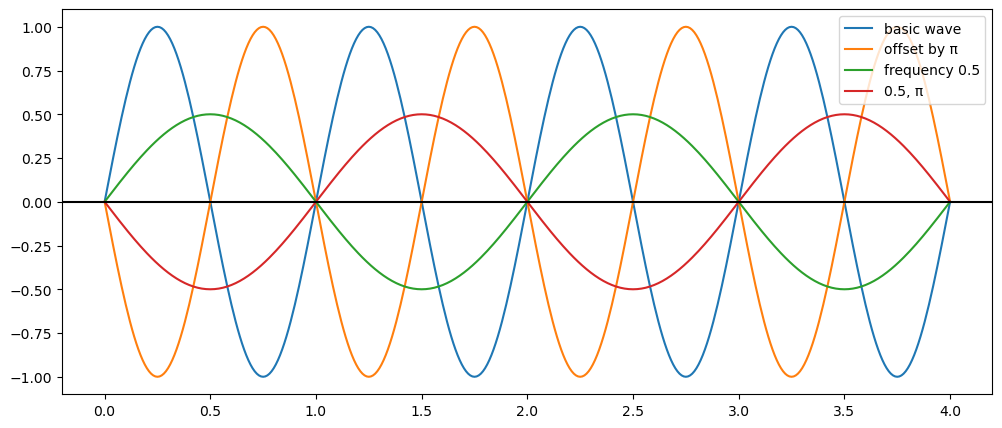

In [33]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, sine_wave(1.0, xs), label="basic wave")
    plt.plot(xs, sine_wave(1.0, xs, np.pi), label="offset by π")
    plt.plot(xs, sine_wave(0.5, xs) * 0.5, label="frequency 0.5")
    plt.plot(xs, sine_wave(0.5, xs, np.pi) * 0.5, label="0.5, π")
    plt.axhline(y=0, color="black")
    plt.legend()

In [34]:
def sawtooth_wave(frequency: float, time: npt.ArrayLike, phase: float = 0.0,
                  amplitude: float = 1.0):
    return (signal.sawtooth(2.0 * np.pi * time * frequency + phase + np.pi / 2,
                            0.5) * amplitude)

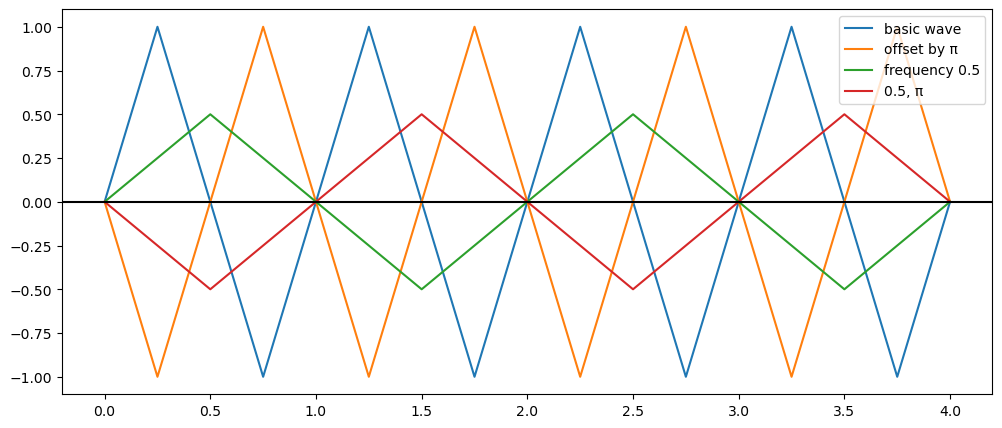

In [35]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, sawtooth_wave(1.0, xs), label="basic wave")
    plt.plot(xs, sawtooth_wave(1.0, xs, np.pi), label="offset by π")
    plt.plot(xs, sawtooth_wave(0.5, xs, amplitude=0.5), label="frequency 0.5")
    plt.plot(xs, sawtooth_wave(0.5, xs, phase=np.pi, amplitude=0.5), label="0.5, π")
    plt.axhline(y=0, color="black")
    plt.legend()

In [36]:
def square_wave(frequency: float, time: npt.ArrayLike, phase: float = 0.0,
                amplitude: float = 1.0):
    return signal.square(2.0 * np.pi * time * frequency + phase, 0.5) * amplitude

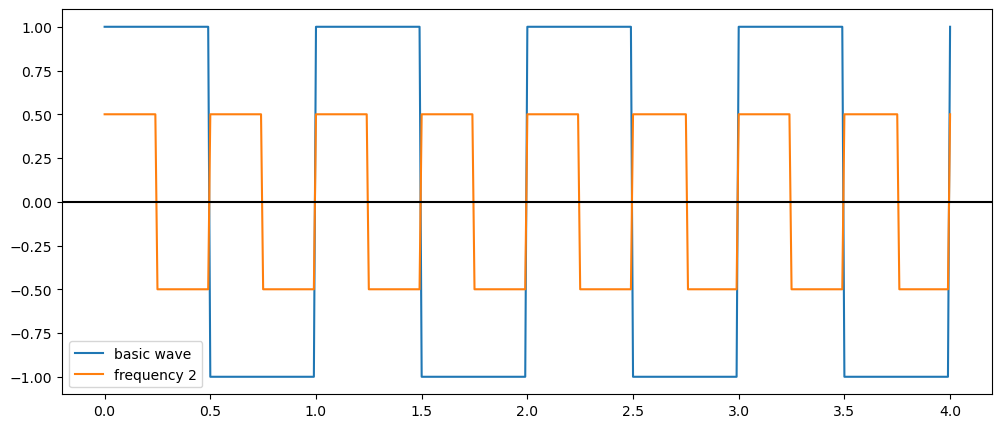

In [37]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, square_wave(1.0, xs), label="basic wave")
    plt.plot(xs, square_wave(2.0, xs, amplitude=0.5), label="frequency 2")
    plt.axhline(y=0, color="black")
    plt.legend()

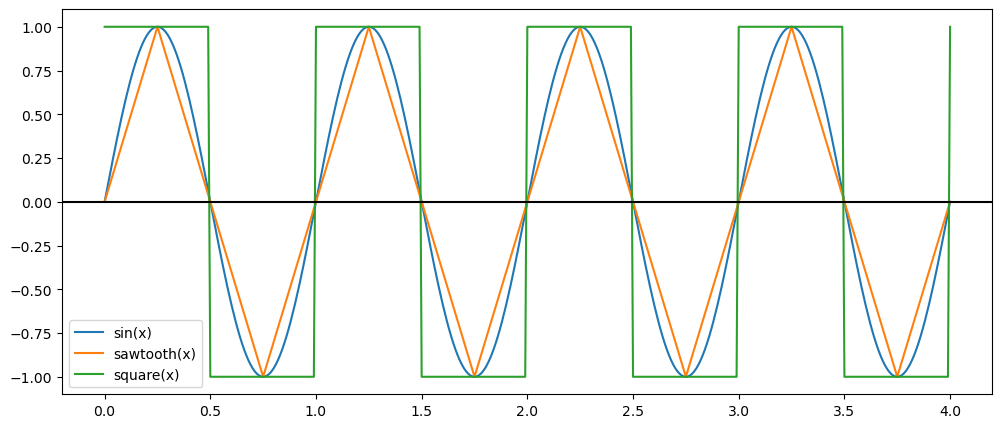

In [38]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, sine_wave(1.0, xs), label="sin(x)")
    plt.plot(xs, sawtooth_wave(1.0, xs), label="sawtooth(x)")
    plt.plot(xs, square_wave(1.0, xs), label="square(x)")
    plt.axhline(y=0, color="black")
    plt.legend()

In [39]:
WAVE_FUNCTIONS = {
    "Sine Wave": sine_wave, "Sawtooth Wave": sawtooth_wave, "Square Wave": square_wave,
}

In [40]:
def apply_noise(fun, noise_scale=0.1, noise_loc=0.0):
    def noisy_fun(frequency, time, phase=0.0, amplitude=1.0):
        noise = np.random.normal(loc=noise_loc, scale=noise_scale, size=np.shape(time))
        return fun(frequency, time, phase=phase, amplitude=amplitude) + noise

    return noisy_fun

In [41]:
xs = np.linspace(0, 2.0, 201)

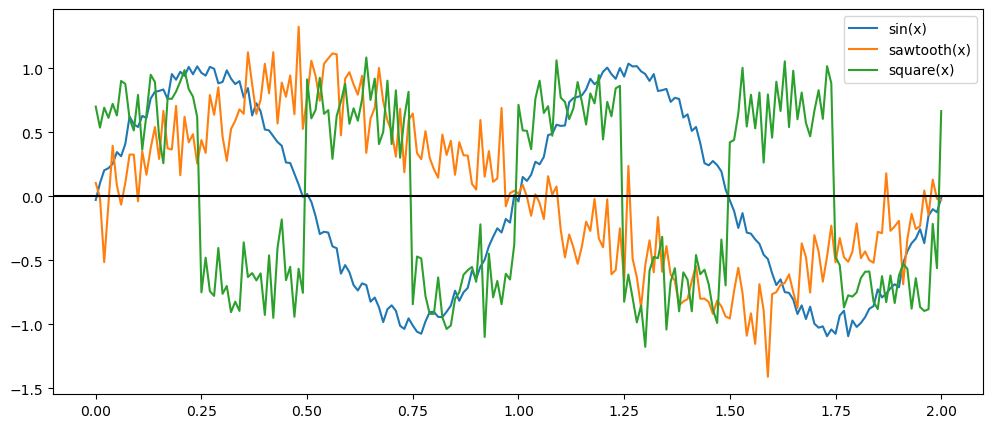

In [42]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, apply_noise(sine_wave, 0.05)(1.0, xs), label="sin(x)")
    plt.plot(xs, apply_noise(sawtooth_wave, 0.2)(0.5, xs), label="sawtooth(x)")
    plt.plot(xs, apply_noise(square_wave, 0.2)(2, xs, amplitude=0.7), label="square(x)")
    plt.axhline(y=0, color="black")
    plt.legend()

In [43]:
@dataclass
class Device:
    name: str
    amplitude: float = field(default=1.0)
    frequency: float = field(default=1.0)
    phase: float = field(default=0.0)
    noise_scale: float = field(default=0.1)
    noise_loc: float = field(default=0.0)
    value_function: callable = field(default=sine_wave)
    n_samples_per_cycle: int = field(default=20)
    cycle_time: float = field(default=1.0)
    delay_per_call: float = field(default=0.0)
    _current_time: float = field(default=0.0)

    def get_measurements(self):
        sleep(self.delay_per_call)
        current_time: float = self._current_time
        self._current_time += self.cycle_time
        n = self.n_samples_per_cycle
        ts = np.linspace(current_time, current_time + self.cycle_time, n,
                         endpoint=False)
        fun = apply_noise(self.value_function, noise_loc=self.noise_loc,
                          noise_scale=self.noise_scale)
        return list(fun(self.frequency, ts, phase=self.phase, amplitude=self.amplitude))

    def reset(self):
        self._current_time = 0.0

In [44]:
device_1 = Device("device 1", cycle_time=1.0)
device_2 = Device("device 2", amplitude=0.8, frequency=0.5, noise_scale=0.2,
                  value_function=square_wave, cycle_time=1.0, )

In [45]:
device_1.get_measurements()

[-0.07270699500503004,
 0.17452466942212072,
 0.7047825183156587,
 0.8125376258859395,
 1.051481770567688,
 0.9941178089153112,
 0.8822775797122913,
 0.872879795887788,
 0.6692803352729999,
 0.3848981971272813,
 0.1311341709906437,
 -0.24094030323326227,
 -0.6170563822656243,
 -0.876321393123553,
 -0.9277647116827572,
 -0.9140945403599441,
 -0.9033649682494912,
 -0.8972517016106847,
 -0.6775295385370341,
 -0.2645205022963267]

In [46]:
ys_1, ys_2 = [], []
n_measurements = 4
for t in range(n_measurements):
    ys_1.extend(device_1.get_measurements())
    ys_2.extend(device_2.get_measurements())
xs = np.linspace(0.0, n_measurements, len(ys_1), endpoint=False)

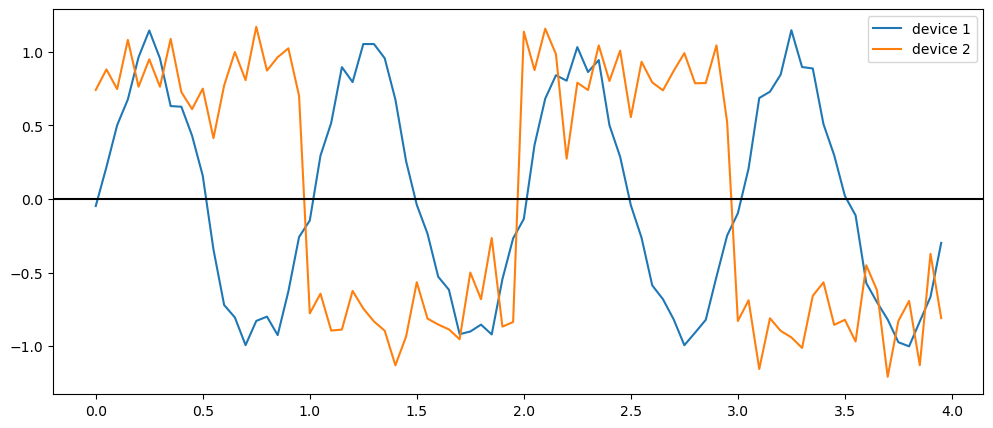

In [47]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, ys_1, label="device 1")
    plt.plot(xs, ys_2, label="device 2")
    plt.axhline(y=0, color="black")
    plt.legend()

In [48]:
class DeviceList(UserList):
    def __init__(self, devices: Optional[list[Device]] = None,
                 n_samples_per_second: int = 20):
        self.n_samples_per_second = n_samples_per_second
        if devices is None:
            devices = []
        else:
            for device in devices:
                device.n_samples_per_cycle = n_samples_per_second
        super().__init__(devices)

    def get_measurements(self):
        return [device.get_measurements() for device in self]

    def reset(self):
        for d in self:
            d.reset()

    @property
    def names(self):
        return [device.name for device in self]

In [49]:
ds = DeviceList([device_1, device_2])
# noinspection PyStatementEffect
ds

DeviceList([Device(name='device 1', amplitude=1.0, frequency=1.0, phase=0.0, noise_scale=0.1, noise_loc=0.0, value_function=<function sine_wave at 0x0000018A1566B490>, n_samples_per_cycle=20, cycle_time=1.0, delay_per_call=0.0, _current_time=5.0),
            Device(name='device 2', amplitude=0.8, frequency=0.5, phase=0.0, noise_scale=0.2, noise_loc=0.0, value_function=<function square_wave at 0x0000018A161D2C20>, n_samples_per_cycle=20, cycle_time=1.0, delay_per_call=0.0, _current_time=4.0)])

In [50]:
np.shape(ds.get_measurements())

(2, 20)

In [51]:
n_measurements = 4
measurements = []
ds.reset()
for t in range(n_measurements):
    measurements.append(np.array(ds.get_measurements()))
np.shape(measurements)

(4, 2, 20)

In [52]:
ys = np.concatenate(measurements, axis=1)
xs = np.linspace(0.0, n_measurements, np.shape(ys)[1], endpoint=False)

np.shape(xs), np.shape(ys)

((80,), (2, 80))

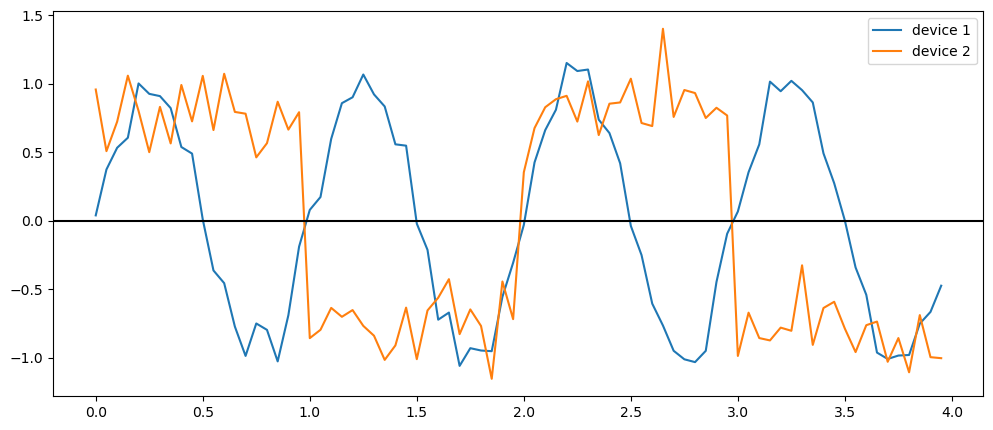

In [53]:
if interactive:
    plt.figure(figsize=(12, 5))
    plt.plot(xs, ys.T, label=ds.names)
    plt.axhline(y=0, color="black")
    plt.legend()

In [54]:
class MeasurementApp:
    def __init__(self, n_devices: int = 3, n_samples_per_cycle=4,
                 n_displayed_cycles=100, max_retained_samples=1_000,
                 delay_per_call=0.5):

        self.executor = ThreadPoolExecutor(max_workers=2)

        # Filled in by `add_plot_frame()`.
        self.axes = None
        self.figure = None
        self.figure_canvas = None

        # @formatter:off
        devices = DeviceList([
            Device(f"Device {n + 1}", n_samples_per_cycle=n_samples_per_cycle,
                   cycle_time=0.1, delay_per_call=delay_per_call)
            for n in range(n_devices)])
        # @formatter:on
        self.n_samples_per_cycle = n_samples_per_cycle
        self.displayed_cycles = n_displayed_cycles
        self.n_displayed_samples = n_samples_per_cycle * n_displayed_cycles
        self.max_retained_samples = max_retained_samples

        self.xs = np.zeros(1)
        self.ys = np.zeros((n_devices, 1))
        self.should_devices_run = False

        self.devices = devices
        # An array of Variable instances so that they don't get garbage collected.
        self._variables = []

        root = tk.Tk()
        root.title("Perform Measurements")
        root.columnconfigure(1, weight=1, minsize=200)
        root.rowconfigure(1, weight=1)
        self.root = root

        main_frame = ttk.Frame(root, padding="3 3 12 12")
        main_frame.grid(column=1, row=1, sticky="NSEW")
        main_frame.columnconfigure(1, weight=1, minsize=200)
        main_frame.columnconfigure(2, weight=2, minsize=400)
        main_frame.rowconfigure(999, weight=1)

        for row, device in enumerate(devices, 1):
            self.add_device_panel(main_frame, device, row)

        self.add_plot_frame(main_frame)

        button_frame = ttk.Frame(main_frame)
        button_frame.grid(column=2, row=10, sticky="E")
        self.run_async_button = ttk.Button(button_frame, command=self.run_devices_async,
                                           text="Run Async")
        self.run_async_button.grid(column=1, row=1, padx=12, sticky="E")
        self.run_button = ttk.Button(button_frame, command=self.run_devices, text="Run")
        self.run_button.grid(column=2, row=1, padx=12, sticky="E")

    def add_device_panel(self, parent, device, row):
        def update_device_name(*_args):
            device.name = name_var.get()

        def update_device_function(*_args):
            device.value_function = WAVE_FUNCTIONS[function_var.get()]

        def update_device_frequency(*_args):
            device.frequency = frequency_var.get()

        def update_device_amplitude(*_args):
            device.amplitude = amplitude_var.get()

        def update_device_phase(*_args):
            device.phase = phase_var.get()

        frame = ttk.Frame(parent)
        frame["borderwidth"] = 2
        frame["relief"] = "raised"
        frame.grid(column=1, row=row, sticky="NSEW")
        frame.rowconfigure(999, weight=1)
        frame.columnconfigure(2, weight=1)

        ttk.Label(frame, text="Name:").grid(column=1, row=1, sticky="E")
        name_var = tk.StringVar(value=device.name)
        name_var.trace_add("write", update_device_name)
        self._variables.append(name_var)
        name_entry = ttk.Entry(frame, width=6, textvariable=name_var)
        name_entry.grid(column=2, row=1, sticky="EW")

        ttk.Label(frame, text="Wave Function:")
        function_var = tk.StringVar()
        function_var.trace_add("write", update_device_function)
        self._variables.append(function_var)
        function_menu = ttk.OptionMenu(frame, function_var, "Sine Wave",
                                       *list(WAVE_FUNCTIONS.keys()))
        function_menu.grid(column=2, row=2, sticky="EW")

        ttk.Label(frame, text="Frequency:").grid(column=1, row=3, sticky="E", padx=12)
        initial_frequency = device.frequency
        frequency_var = tk.DoubleVar()
        frequency_var.trace_add("write", update_device_frequency)
        self._variables.append(frequency_var)
        frequency_scale = ttk.LabeledScale(frame, variable=frequency_var, from_=0.1,
                                           to=4.0)
        frequency_scale.grid(column=2, row=3, sticky="EW", padx=12)
        frequency_var.set(initial_frequency)

        ttk.Label(frame, text="Amplitude:").grid(column=1, row=4, sticky="E", padx=12)
        initial_amplitude = device.amplitude
        amplitude_var = tk.DoubleVar()
        amplitude_var.trace_add("write", update_device_amplitude)
        self._variables.append(amplitude_var)
        amplitude_scale = ttk.LabeledScale(frame, variable=amplitude_var, from_=0.5,
                                           to=4.0)
        amplitude_scale.grid(column=2, row=4, sticky="EW", padx=12)
        amplitude_var.set(initial_amplitude)

        ttk.Label(frame, text="Phase:").grid(column=1, row=5, sticky="E", padx=12)
        initial_phase = device.phase
        phase_var = tk.DoubleVar()
        phase_var.trace_add("write", update_device_phase)
        self._variables.append(phase_var)
        phase_scale = ttk.LabeledScale(frame, variable=phase_var, from_=0.0,
                                       to=2 * np.pi)
        phase_scale.grid(column=2, row=5, sticky="EW", padx=12)
        phase_var.set(initial_phase)

    def add_plot_frame(self, parent):
        plot_frame = ttk.Frame(parent, padding="3 3 12 12")
        plot_frame.grid(column=2, row=1, sticky="NSEW", rowspan=len(self.devices))

        # TODO: Should this be set to device DPI?
        self.figure = Figure(figsize=(8, 4), dpi=120)
        self.figure_canvas = FigureCanvasTkAgg(figure=self.figure, master=plot_frame)
        NavigationToolbar2Tk(self.figure_canvas, plot_frame)
        self.axes = self.figure.add_subplot()
        self.axes.set_title("Device Measurements")
        self.figure_canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    def run_devices(self, *_args):
        self.should_devices_run = True
        self.run_button["command"] = self.stop_devices
        self.run_button["text"] = "Stop"
        self.run_async_button["state"] = "disabled"
        self.update_devices()

    def stop_devices(self, *_args):
        self.should_devices_run = False
        self.run_button["command"] = self.run_devices
        self.run_button["text"] = "Run"
        self.run_async_button["state"] = "normal"

    def run_devices_async(self, *_args):
        self.should_devices_run = True
        self.run_async_button["command"] = self.stop_devices_async
        self.run_async_button["text"] = "Stop"
        self.run_button["state"] = "disabled"
        self.update_devices_async()

    def update_devices(self):
        self.update_measurements()
        self.update_figure()
        if self.should_devices_run:
            self.root.after(100, self.update_devices)
        else:
            # Stop devices
            pass

    def stop_devices_async(self, *_args):
        self.should_devices_run = False
        self.run_async_button["command"] = self.run_devices_async
        self.run_async_button["text"] = "Run Async"
        self.run_button["state"] = "normal"

    def update_devices_async(self):
        def finish_update(_future):
            self.update_figure()
            if self.should_devices_run:
                self.root.after(100, self.update_devices_async)

        future = self.executor.submit(self.update_measurements)
        future.add_done_callback(finish_update)

    def update_measurements(self):
        new_measurements = self.devices.get_measurements()
        new_ys = np.concatenate([self.ys, new_measurements], axis=1)
        self.ys = new_ys[:, -self.max_retained_samples:]
        start_x = self.xs[-1] + 1
        new_xs = np.arange(start_x, start_x + np.shape(new_measurements)[1])
        self.xs = np.concatenate([self.xs, new_xs])[-self.max_retained_samples:]

    def update_figure(self):
        self.axes.cla()
        x_max = self.xs[-1]
        x_min = max(0, x_max - self.n_displayed_samples)
        self.axes.set_xlim(x_min, x_max)
        self.axes.plot(self.xs, self.ys.T, label=self.devices.names)
        self.axes.legend(loc="upper right")
        self.figure_canvas.draw()

    def run(self):
        self.root.mainloop()

In [58]:
if __name__ == "__main__":
    app = MeasurementApp(delay_per_call=0.5)
    app.run()